# Objective

Develop an agent-based model to simulate pandemic spread dynamics and explore the impact of intervention strategies, such as social distancing, on infection rates and recovery.

---

## A. Building the Base Model: Infection Dynamics in a Population

### 1. Define the Environment and Initial Conditions

- Create a 75 × 75 voxel grid representing a bounded area where individuals (agents) can move and interact.
- Populate the grid with 100 agents, initialized randomly in the following states:

    - 95 agents: Susceptible (S) — individuals at risk of infection.  
    - 5 agents: Infected (I) — individuals who can transmit the infection.  
    - 0 agents: Recovered (R) — individuals who have recovered and are immune.


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [109]:
def initialize(seed = 1024, grid_w = 75, N = 100, size = 5):
    np.random.seed(seed)

    # initialize and set susceptible people
    states = np.zeros(N, dtype = int)
    # set infected people
    infected_indices = np.random.choice(N, size=size, replace=False)
    states[infected_indices] = 1

    # initialize their position on the grid.
    positions = np.random.randint(0, grid_w, size = (N, 2))

    return states, positions

states, positions = initialize()
print('S', np.sum(states == 0))
print('I', np.sum(states == 1))
print(positions[:5])

S 95
I 5
[[31 42]
 [12 67]
 [48 66]
 [62 64]
 [56 14]]


### 2. Define Agent Behaviors

- Movement: Each agent moves to a neighboring cell each time step (up, down, left, right, or stays in place). Movement can be random or follow simple rules, e.g., random walk (Brownian motion) or Levy walk.
- Transmission: If a susceptible agent shares a cell with an infected agent, there is a probability $p$ that the susceptible agent becomes infected.
- Recovery: Infected agents have a probability q of recovering at each time step, after which they transition to the recovered state.

In [94]:
def movement(positions, grid_w = 75, grid_h = 75):
    directions = np.array([[0,-1],[0,1],[-1,0],[1,0], [0,0]]) # left, right, up, down, stay
    movement_indices = np.random.randint(0, 5, size = len(positions))
    moves = directions[movement_indices]
    positions = positions + moves

    # keep agents within grid bounds (clip to [0, 74])
    positions[:, 0] = np.clip(positions[:, 0], 0, grid_w - 1)
    positions[:, 1] = np.clip(positions[:, 1], 0, grid_h - 1)

    return positions

print('before', positions[:5])
print('after', movement(positions)[:5])

before [[31 42]
 [12 67]
 [48 66]
 [62 64]
 [56 14]]
after [[31 43]
 [12 67]
 [49 66]
 [61 64]
 [55 14]]


In [95]:
def transmission(positions, states, p):
    res_states = states.copy()
    # find out who are in the same cell
    unique_cells, inverse_indices = np.unique(positions, axis=0, return_inverse=True)
    #print(unique_cells[:10], inverse_indices[:10])
    # inverse_indices maps each position to its unique cell’s index
    for i in range(len(unique_cells)):
        shared_cell_indices = np.where(i == inverse_indices)[0]
        shared_cell_states = states[shared_cell_indices]
        # infection
        if np.any(shared_cell_states == 1) and np.any(shared_cell_states == 0):
            s_cell_indices = shared_cell_indices[shared_cell_states == 0]
            i_or_not = np.random.rand(len(s_cell_indices)) < p # True = get infected
            res_states[s_cell_indices[i_or_not]] = 1
    return res_states

print('before', states)
print('after', transmission(positions, states, p = 0.5))

before [0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
after [0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]


In [96]:
def recovery(positions, states, q):
    res_states = states.copy()
    infected_agents_indices = np.where(states == 1)[0]
    r_or_not = np.random.rand(len(infected_agents_indices)) < q
    recovered_indices = infected_agents_indices[r_or_not]
    res_states[recovered_indices] = 2
    return res_states

print('before', states)
print('after', recovery(positions, states, q = 0.5))

before [0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
after [0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]


### 3. Run the Simulation

- Simulate the model over 200 time steps, recording the population counts in each compartment (susceptible, infected, recovered ) at each step.
-  Plot the number of agents in each state over time to visualize infection spread, recovery, and eventual immunity.

In [97]:
states, positions = initialize(111)

def pop_count(states):
    s = len(np.where(states == 0)[0])
    i = len(np.where(states == 1)[0])
    r = len(np.where(states == 2)[0])
    res = [s, i, r]
    return res

def simulate(states, positions, p = 0.5, q = 0.01):
    pop_counts = []
    for i in range(200):
        positions = movement(positions)                         
        states = transmission(positions, states, p)
        states = recovery(positions, states, q) 

        pop_counts.append(pop_count(states))
        res = np.array(pop_counts)
    return res

pop_counts = simulate(states, positions)

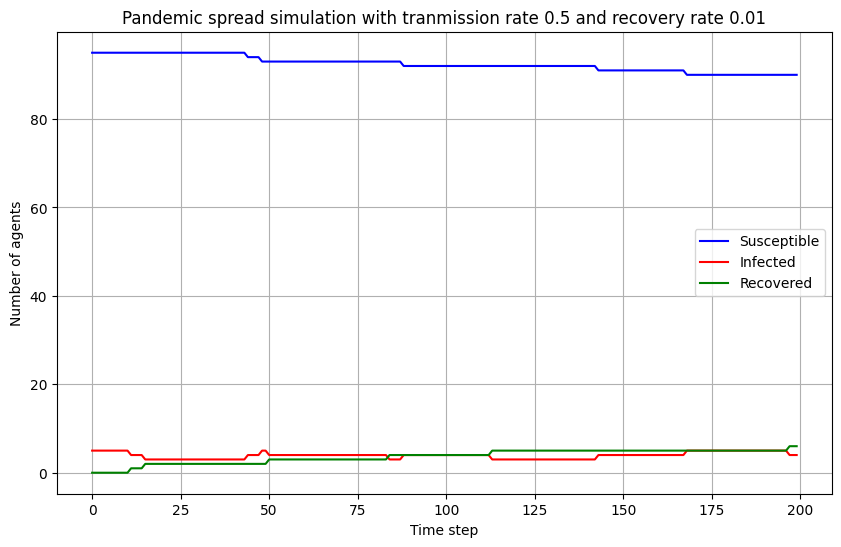

In [98]:
def plot(pop_counts, p = 0.5, q = 0.01):
    time_steps = np.arange(len(pop_counts))

    plt.figure(figsize=(10,6))
    plt.plot(time_steps, pop_counts[:, 0], label='Susceptible', color='blue')
    plt.plot(time_steps, pop_counts[:, 1], label='Infected', color='red')
    plt.plot(time_steps, pop_counts[:, 2], label='Recovered', color='green')

    plt.xlabel('Time step')
    plt.ylabel('Number of agents')
    plt.title(f'Pandemic spread simulation with tranmission rate {p} and recovery rate {q}')
    plt.legend()
    plt.grid(True)
    plt.show()

plot(pop_counts)

### 4. Sensitivity Analysis

- Test different values of p (infection probability) and q (recovery probability). For instance, run simulations with p= 0.05,0.1 and q= 0.02,0.05.
- Analyze how changes in pand qimpact infection peaks, time to infection peak, and overall population recovery.
- Rerun the simulation with other random initial conditions. Compare the plots across different runs and plot the average of each population subgroup over time. Do you see some average trend across the random initial conditions?

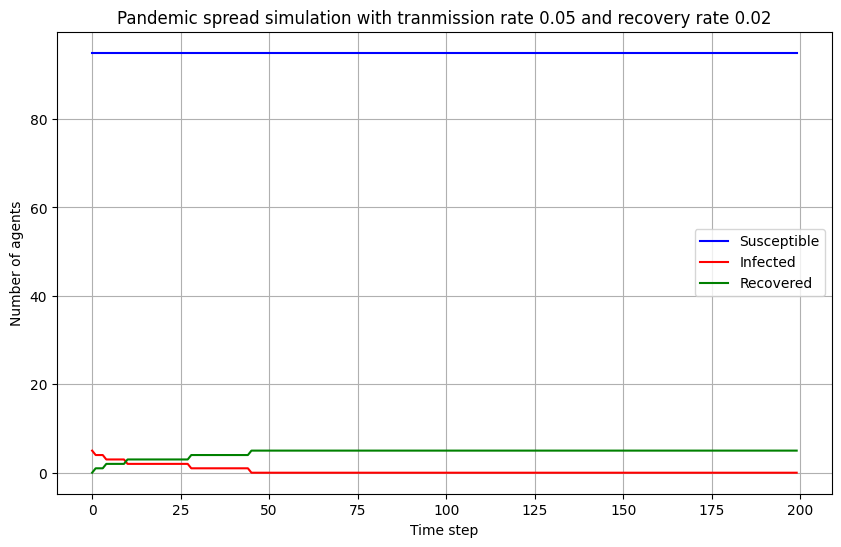

In [99]:
res1 = simulate(states, positions, p = 0.05, q = 0.02)
plot(res1, p = 0.05, q = 0.02)

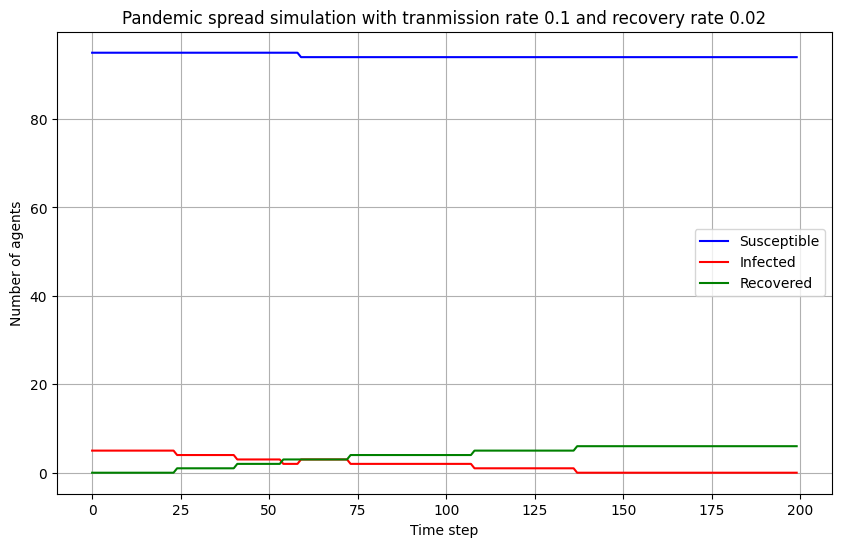

In [87]:
res2 = simulate(states, positions, p = 0.1, q = 0.02)
plot(res2, p = 0.1, q = 0.02)

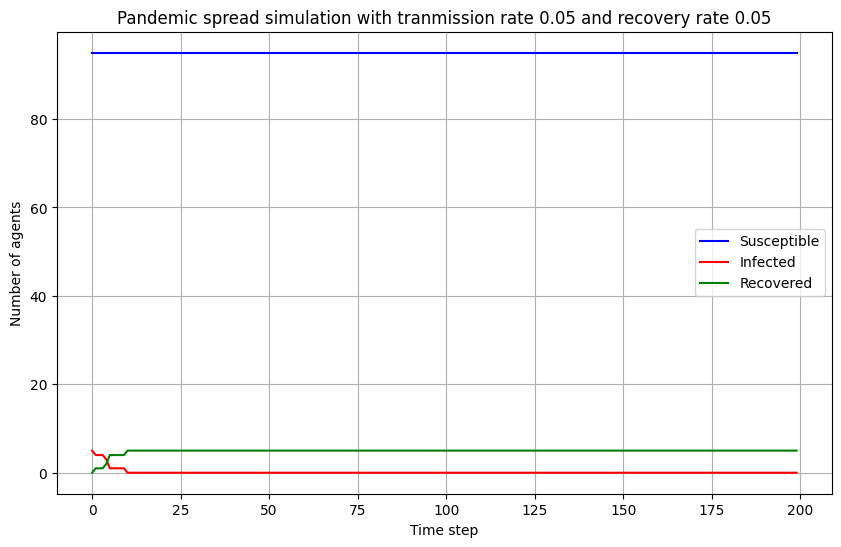

In [86]:
res3 = simulate(states, positions, p = 0.05, q = 0.05)
plot(res3, p = 0.05, q = 0.05)

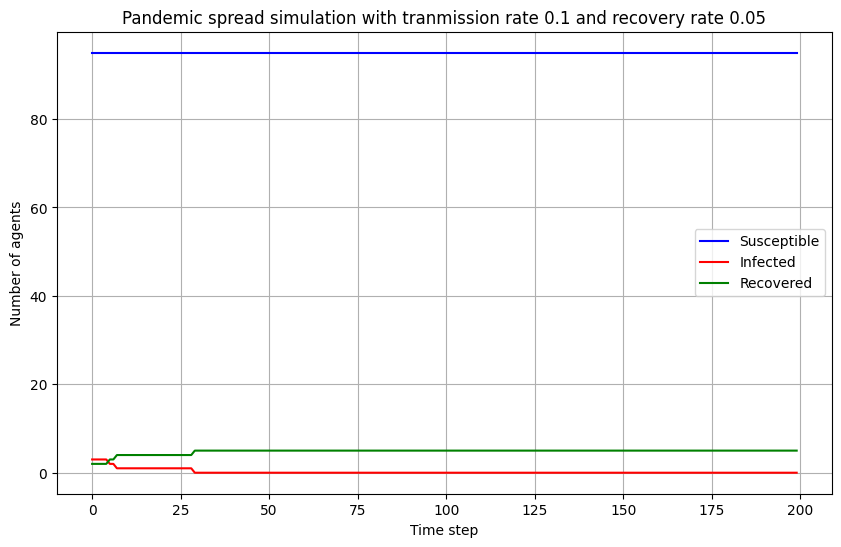

In [85]:
res4 = simulate(states, positions, p = 0.1, q = 0.05)
plot(res4, p = 0.1, q = 0.05)

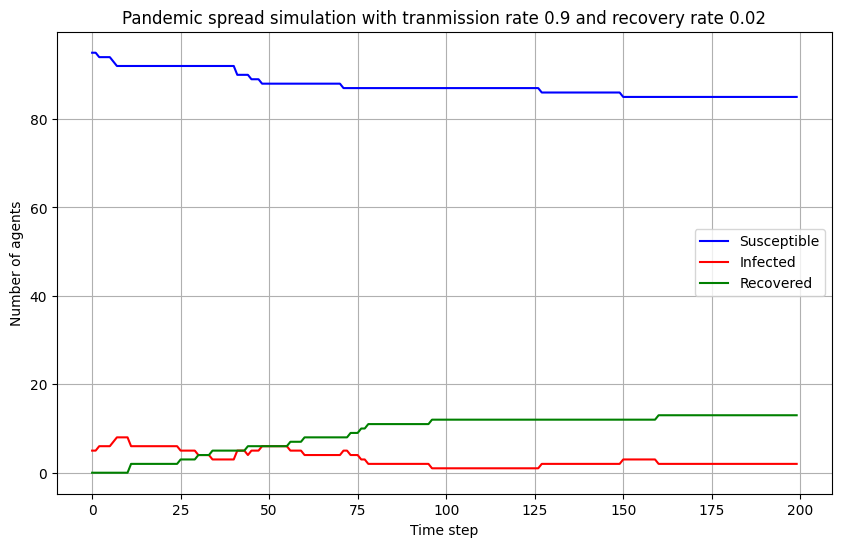

In [115]:
states, positions = initialize(seed = 1024, grid_w = 50, N = 100, size = 5)
p = 0.9
q = 0.02
res5 = simulate(states, positions, p = 0.9, q = 0.02)
plot(res5, p = p, q = q)


## B. Extending the Model: Social Distancing and Intervention Strategies

### 1. Introduce Social Distancing Measures: Modify agent movement behavior to simulate social distancing. 

For instance:

- When agents have a reduced probability of moving at each step, limiting their interactions. Which parameter of the model should be changed to model this?
- When agents actively move away from cells with infected individuals when possible, simulating avoidance behavior. Which parameter of the model should be changed to model this?
- Run the simulation for 200 steps with social distancing measures in place, recording and plotting the average compartment counts across multiple runs (with random initial states) over time as before.
- Which parameter impacts the maximum number of infected subjects at each time window to prevent the healthcare system overwhelm?
